# Lattice example for frequency allocation
Authors: Alexis Morvan

Date: September 2021

This notebook aims at show how to calculate the yield of a lattice after optimizing the smaller system with periodic boundayr condition. In order to construct both the motif and the lattice, we use the exremely good package pybinding that allow to construct lattice very easily.

## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo warning
import logging

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

## Construction of the lattice
To construct the square lattice, we are using the pybinding lattice that allow use to imput all the edge. Luckily, pybinding lattice structure also keep the direction of the edge which will be very useful for the Cross-Resonance interaction

In [4]:
import pybinding as pb
import itertools

def square_lattice(n):
    """ Construct a square lattice of size side n"""

    d = 1  # placeholder
    t = 1    # placeholder

    # create a simple 2D lattice with vectors a1 and a2
    lattice = pb.Lattice(a1=[n, 0], a2=[0, n])
    lattice.add_sublattices( *[(f"A_{i}_{j}", [i, j]) for (i, j) in itertools.product(range(n), repeat=2)])

    # add the hopping for the internal sub-lattice
    lattice.add_hoppings( *[ ([0, 0], f'A_{i}_{j}', f'A_{i+1}_{j}', t)
                           for i,j in itertools.product(range(n//2), range(n))]
    )
    lattice.add_hoppings( *[ ([0, 0], f'A_{i}_{j}', f'A_{i}_{j+1}', t)
                           for i,j in itertools.product(range(n), range(n//2))]
    )

    # add the hopping for the internal sub-lattice
    lattice.add_hoppings( *[ ([0, 0], f'A_{i+1}_{j}', f'A_{i}_{j}', t)
                           for i,j in itertools.product(range(n//2, n-1), range(n))]
    )
    lattice.add_hoppings( *[ ([0, 0], f'A_{i}_{j+1}', f'A_{i}_{j}', t)
                           for i,j in itertools.product(range(n), range(n//2, n-1))]
    )

    # now the link between subregions
    lattice.add_hoppings( *[ ([1, 0], f'A_{n-1}_{j}', f'A_{0}_{j}', t)
                           for j in range(n)]
    )
    lattice.add_hoppings( *[ ([0, 1], f'A_{i}_{n-1}', f'A_{i}_{0}', t)
                           for i in range(n)]
    )
    
    return lattice

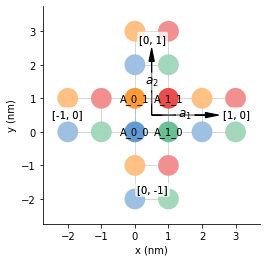

In [12]:
lattice = square_lattice(2)

lattice.plot()  # plot the lattice that was just constructed
plt.show()      # standard matplotlib show() function


## Some definition for the threshold etc...

In [15]:
architecture = "CR"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

elif (architecture == 'CR') and qutrit:
    d_dict = {'A1': 0.017,
              'A2i': 0.03,
              'A2j': 0.03,
              'A3i': 0.03,
              'A3j': 0.03,
              "E1": 0.017,
              "E2": 0.03,
              "E3": 0.03,
              "E4":0.002,
              "F1": 0.017,
              "F2":0.025,
              "F3": 0.025,
              "M1": 0.017}
    cr_keys = ['A1', 'A2i', 'A2j','A3i', 'A3j', "E1", "E2","E3", "E4",
               "C1", "C1b", "F1", "F2","F3",  "M1"]
    cstr_key = cr_keys
    
    
# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

## Optimizing the motif model for the sqaure layout

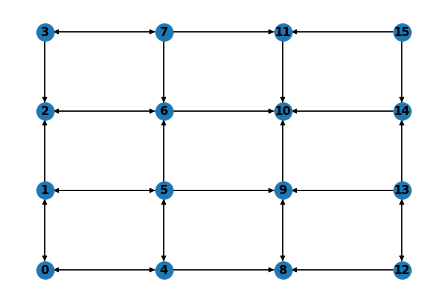

In [27]:
n = 4

lattice = square_lattice(n)
edges = [(y.from_id, y.to_id) for y in lattice.hoppings['__anonymous__0'].terms]
pos = {y.unique_id: y.position[:2] for y in lattice.sublattices.values()}  # only taking 2D

# define the frequency graph
G = FrequencyGraph(edges=edges, cz=cz)

# plot if needed
G.plot(pos=pos)

# In the plot, some of the interaction are actually on top of each other, making it hard to see

In [28]:
# defining the optimizer
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             all_differents=all_differents)

# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
print("first pass done")
result = optimizer.second_pass()
print("second pass done")
result = optimizer.third_pass()
print("third pass done")

first pass done
second pass done
third pass done


The drive frequency are CR compatible
11 11 11
True


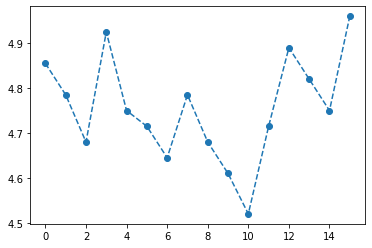

In [29]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)
print(G.check_solution(d_dict, cstr=cstr_key))
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')

11 11 11
Qubit collisions:
yield   = 0.73399
average = 0.61299


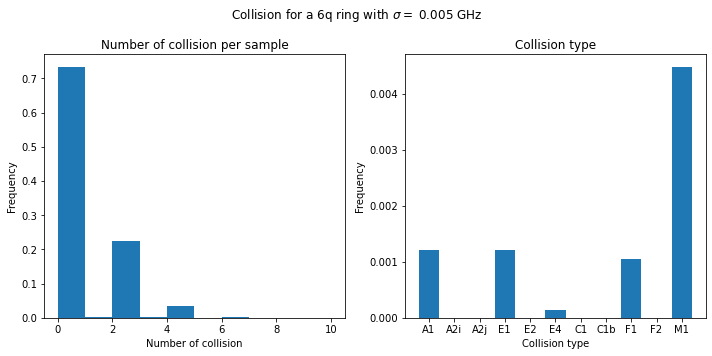

In [42]:
# parametrization
Nsamples = 1e5
sigma = 0.005

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict,
                                                       sigma=sigma,
                                                       qutrit=qutrit,
                                                       cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(constraints)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11


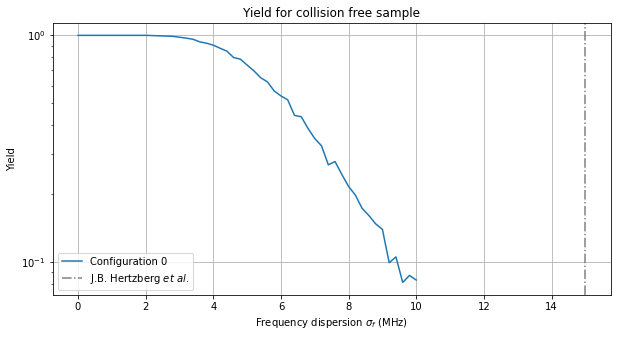

In [43]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 1000

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.01, 51)

# saving the results
collisions = np.array([G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()